# Particle filter implementation on ship tracking

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import math

Text(0.5, 0, 'Time')

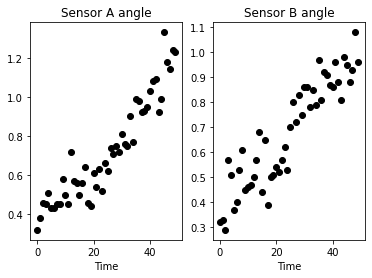

In [94]:
N = 50 # number of time points

yA = np.loadtxt('sensorA.txt')
yB = np.loadtxt('sensorB.txt')
y = np.vstack((yA, yB))

plt.figure()
plt.subplot(121)
plt.plot(yA, 'ko')
plt.title("Sensor A angle")
plt.xlabel("Time")
plt.subplot(122)
plt.plot(yB, 'ko')
plt.title("Sensor B angle")
plt.xlabel("Time")

In [95]:
A = np.eye(4)
delta = 1 / 60
A[0, 2] = delta
A[1, 3] = delta







In [96]:
mu_prior = np.vstack((10, 30, 10, -10))
Sigma_prior = np.diagflat(np.vstack((10**2, 10**2, 5**2, 5**2)))
Sigma_update = np.diagflat(np.vstack((.1**2, .1**2, .5**2, .5**2)))
Sigma_noise = np.diagflat(np.vstack((.1**2, .1**2)))



In [97]:
mu_prop = np.zeros([4, N])
mu_prop[:, 0] = mu_prior.squeeze()
mu_update = np.zeros([4, N])
Sigma_pred = np.zeros([4, 4, N])
Sigma_pred[:, :, 0] = Sigma_prior
Sigma_upd = np.zeros([4, 4, N])
Pred_err = np.zeros([2, N])


In [98]:
B = 10000
L = np.linalg.cholesky(Sigma_prior)
xB = np.zeros([4, B])
xB = mu_prior * np.ones([1, B]) + np.dot(L, np.random.randn(4 * B).reshape(4, B))
xB_update = np.zeros([4, B])
mm = np.zeros([4, N])
mlow = np.zeros([4, N])
mhigh = np.zeros([4, N])




In [106]:
for i in range(N):
    yPB = np.vstack((np.divide(np.arctan(xB[0, :]), np.arctan(xB[1, :])),
                     np.divide(np.arctan(40 - xB[1, :]), np.arctan(40 - xB[0, :]))))
    # print(np.linalg.inv(Sigma_noise[0, 0].reshape(-1, 1)))
    l = -.5 * np.linalg.inv(Sigma_noise[0, 0].reshape(-1, 1)) * np.multiply((
            np.dot(y[:, i].reshape(-1, 1), np.ones([1, B])) - yPB),
            (np.dot(y[:, i].reshape(-1, 1), np.ones([1, B])) - yPB))
    w = l[0, :] + l[1, :]
    ew = np.exp(w)
    nw = ew / np.sum(ew)
    Fw = np.cumsum(nw)
    xBupd = np.zeros([4, B])
    for kk in range(B):
        Ur = np.random.rand()
        ind = np.argmin(np.abs(Fw - Ur))
        xBupd[:, kk] = xB[:, ind]
    mm[:, i] = np.mean(xBupd, axis = 1)
    for ik in range(4):
        ms = np.sort(xBupd[ik, :])
        mlow[ik, i] = ms[int(np.ceil(.05 * B))]
        mhigh[ik, i] = ms[int(np.floor(.95 * B))]
    if i < N:
        xB = np.dot(A, xBupd) + np.dot(np.linalg.cholesky(Sigma_update), np.random.randn(4 * B).reshape(4, B))





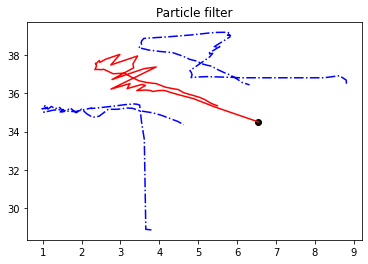

In [108]:
plt.figure()
plt.plot(mm[0,0], mm[1, 0], 'ko')
plt.title("Particle filter")
plt.plot(mm[0, :], mm[1, :], 'r')
plt.plot(mlow[0, :], mlow[1, :], 'b-.')
plt.plot(mhigh[0, :], mhigh[1, :], 'b-.')
plt.show()